# Exercise 4: Parallel merge sort

In [20]:
# Non-parallel merge sort (implementation provided)
def merge_sort_nonparallel(data):
  if len(data) <= 1:
    return data
  else:
    split = len(data) // 2
    left = iter(merge_sort_nonparallel(data[:split]))
    right = iter(merge_sort_nonparallel(data[split:]))
    result = []
    # note: this takes the top items off the left and right piles
    left_top = next(left)
    right_top = next(right)
    while True:
      if left_top < right_top:
        result.append(left_top)
        try:
          left_top = next(left)
        except StopIteration:
          # nothing remains on the left; add the right + return
          return result + [right_top] + list(right)
      else:
        result.append(right_top)
        try:
          right_top = next(right)
        except StopIteration:
          # nothing remains on the right; add the left + return
          return result + [left_top] + list(left)

In [21]:
# Measure time complexity of merge_sort()
import numpy as np
import time

# Generate sample sizes n
n_values = np.logspace(1, 7, num = 5, base = 10).astype(int)

# Store performance time results
times = []

for n in n_values:
    # Generate random data
    data = np.random.rand(n)

    # Start timer
    start = time.perf_counter()

    # Sort the data
    sorted_data = merge_sort_nonparallel(data)

    # Stop timer
    end = time.perf_counter()

    # Calculate elapsed time
    elapsed = end - start

    # Store performance time
    times.append(elapsed)

Text(0.5, 1.0, 'log-log plot of merge_sort_nonparallel() time complexity')

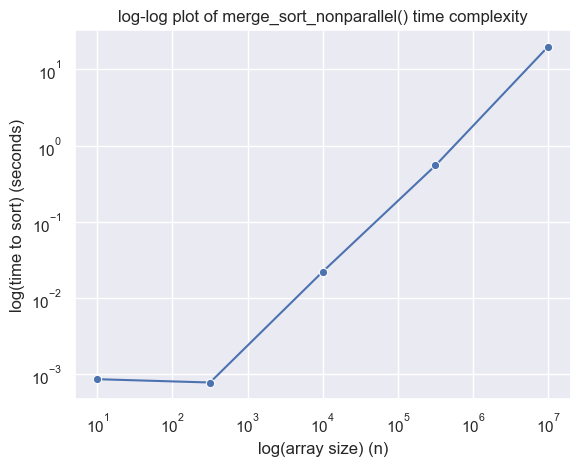

In [22]:
# Plot time complexity of merge_sort()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

df = pd.DataFrame({
    'Array Size': n_values,
    'Time': times
})

sns.set_theme(style="darkgrid")
ax = sns.lineplot(x='Array Size', y='Time', data=df, marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log(array size) (n)')
ax.set_ylabel('log(time to sort) (seconds)')
plt.title('log-log plot of merge_sort_nonparallel() time complexity')

**Interpretation:** This plot appears to show a big-O scaling of $O (n log n)$ for `merge_sort_nonparallel()`. This is apparent because of the linear-looking shape of the line on log-log axis scaling.

In [18]:
# Modified merge sort with non-parallel and parallel option (merge_sort_module.py)

**Note**: Please see merge_sort_module.py for the parallel implementation. I tried to code it in this notebook, but Python complained about pickling and unpickling, and apparently it wasn't going to be satisfied until I separated the parallel merge sort into its own Python script because the multiprocessing module is a special snowflake and can't handle being used from a Jupyter Notebook.

In [25]:
# Comparison of performance
if __name__ == "__main__": # Prevent child processes spawning recursively
    from merge_sort_module import merge_sort
    import time
    import numpy as np

    # Non-parallel merge sort
    data = np.random.rand(10000).tolist()
    start = time.perf_counter()
    sorted_data = merge_sort(data, parallel = False)
    end = time.perf_counter()
    print(f"Non-parallel merge sort performance time: {end - start}")

    # Parallel merge sort
    start = time.perf_counter()
    sorted_data_parallel = merge_sort(data, parallel = True)
    end = time.perf_counter()
    print(f"Two-process parallel merge sort performance time: {end - start}")

Non-parallel merge sort performance time: 0.21692691700081923
Two-process parallel merge sort performance time: 0.040341666997846914


**Discussion of findings:** Parallelized using the `multiprocessing` module, the two-process implementation of `merge_sort()` is nearly an order of magnitude faster. The function splits the data into two halves and creates a new process for each half. Each process runs the original non-parallel merge sort on its half of the data and sends the sorted data back through a pipe. The main process waits to receive both halves of the sorted data, and then merges them together. It should be noted that parallelization creates overhead and is probably not worth the time to figure out for smaller sizes of data.